# CLUSTER SUBMISSION
In this notebook we are going to study the outcome csv file obtained with the IIIA's cluster.

## 1. READ DATA FROM THE CLUSTER SUBMISSION

Every file contains 2 simulations ran with N = 100 agents and T = 4320 hours (4 mesos). There is M = 100 different simulations for each configuration of the norms. Using pandas library we explore the content of the file. 

In [33]:
import pandas as pd
datasets = []
# Iterate over the range from 0 to 10 (exclusive) to read and append each file
for i in range(10):
    filename = f"/resultatssimulacionscluster/results{i}.csv"
    dataset = pd.read_csv(filename, delimiter=";")
    datasets.append(dataset)
cluster = pd.concat(datasets)
cluster.reset_index(drop=True, inplace=True)

# Remove rows with status 'student'
cluster = cluster.loc[cluster['status'] != 'student']

We can join all of our data in a unique dataset so the statistic analysis contains all the information. We can also erase some columns we are not interested in, and locate a particular configuration of norms, like the void subset. Below we can see how many combinations of norms we have.

In [34]:
#cluster = cluster.drop(['iteration', 'name', 'Step', 'position'], axis= 1)
#len(cluster.loc[cluster['norms_ind'] == '()'])
len(pd.unique(cluster['norms_ind'])) 
#cluster.loc[cluster['status'] == 'homeless']
#pd.unique(cluster['Step'])
#cluster.loc[cluster['norms_ind']== '(0,)']

64

Next step will be to plot the wealth distributions corresponding to individual configurations of norms. We use a rug plot to highlight the homeless wealth.

Now we are going to visualize collective subsets of norms. Concretely, the Apo and non-Apo subsets separadetly: 
- (2, 3, 4): Paying a fine when committing a minor crime and/or sleeping in the street, Commuting this fine with days of imprisonment if broke and being evicted from your home. 
- (1, 5, 6 ): Unemployment benefits, Minimal vital income and receiving a Dignified living space. 

### GINI COEFFICIENT
In economics, the Gini coefficient is a measure of statistical dispersion intended to represent the income inequality, the wealth inequality, or the consumption inequality within a nation or a social group. It was developed by statistician and sociologist Corrado Gini.
The Gini coefficient measures the inequality among the values of a frequency distribution, such as levels of income. A Gini coefficient of 0 reflects perfect equality, where all income or wealth values are the same, while a Gini coefficient of 1 (or 100%) reflects maximal inequality among values, for example a single individual having all the income while all others have none.

We can obtain G it by plotting the Lorenz curve (cummulative wealth distribution: share of owned income by each decile of agents) and computing the area between the curve and the perfect line of equality. The final task would be to compute the proportion of this area.  

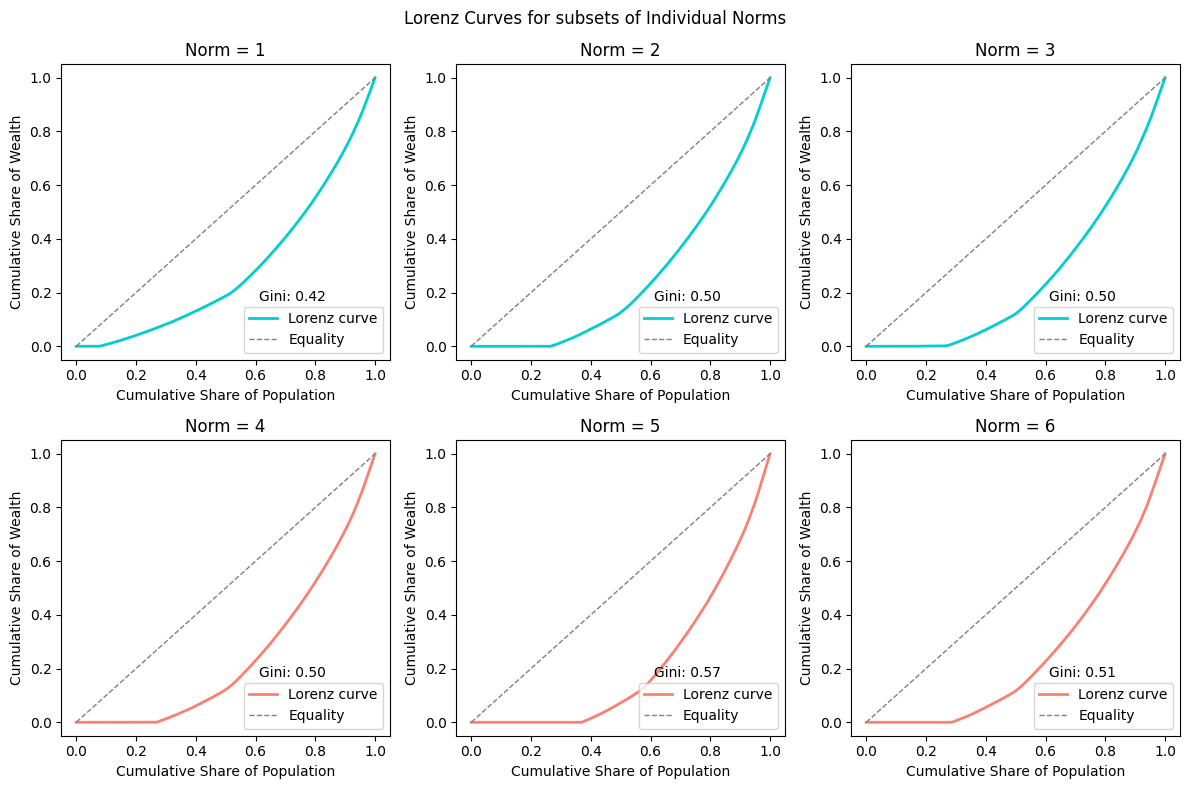

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#CURBA DE LORENTZ AND LINE OF EQUALITY
desired_order = [ '(0,)', '(1,)', '(5,)', '(2,)', '(3,)', '(4,)']
combination_labels = [ '1', '2', '3', '4', '5', '6']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
colors = plt.cm.Set1(np.linspace(0, 1, len(desired_order)))

gini_coefficients = []
colors = ['darkturquoise', 'darkturquoise', 'darkturquoise', 'salmon', 'salmon', 'salmon']  #'salmon', 'darkturquoise']   #plt.cm.Set1(np.linspace(0, 1, len(desired_order)))

# Iterate over the desired combinations and plot the Lorenz curve for each
for i, combination in enumerate(desired_order):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]
    row = i // 3
    col = i % 3
    
    # Compute cumulative wealth distribution
    wealth_values = np.sort(filtered_data['wealth'])
    cumulative_wealth = np.cumsum(wealth_values)
    cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

    # Calculate Gini coefficient
    n = len(cumulative_percentage)
    area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
    area_of_inequality = 0.5 - area_under_curve
    gini_coefficient = area_of_inequality / 0.5
    gini_coefficients.append(gini_coefficient)

    # Plot the Lorenz curve
    axs[row, col].plot(np.linspace(0, 1, n), cumulative_percentage, linewidth=2, label='Lorenz curve', color = colors[i])
    axs[row, col].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Equality')
    
    axs[row, col].set_xlabel('Cumulative Share of Population')
    axs[row, col].set_ylabel('Cumulative Share of Wealth')
    axs[row, col].set_title(f'Norm = {combination_labels[i]}')
    axs[row, col].text(0.6, 0.2, f'Gini: {gini_coefficient:.2f}', transform=axs[row, col].transAxes)
    axs[row, col].legend(loc='lower right')
    
fig.suptitle('Lorenz Curves for subsets of Individual Norms')
plt.tight_layout()
plt.show()


## Baseline simulation

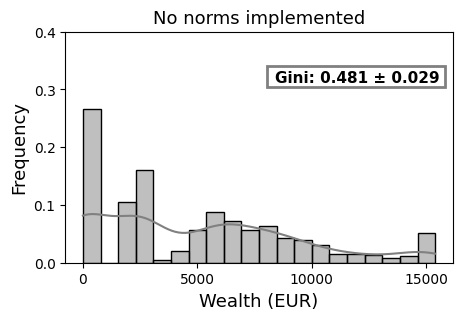

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

desired_order = ['()']
combination_labels = ['norms implemented']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
colors = ['grey']

gini_coefficients = []

# Iterate over the desired combinations and plot the wealth distribution for each
for i, combination in enumerate(desired_order[:1]):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]

    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]

        # Calculate cumulative wealth distribution for the current sample
        wealth_values = np.sort(sample_data['wealth'])
        cumulative_wealth = np.cumsum(wealth_values)
        cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

        # Calculate Gini coefficient for the current sample
        n = len(cumulative_percentage)
        area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
        area_of_inequality = 0.5 - area_under_curve
        gini_coefficient = area_of_inequality / 0.5

        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficients.append((np.mean(sample_ginis), gini_std))
    
  # Plot the distribution of wealth for the current combination with a unique color
    sns.histplot(data=filtered_data, x='wealth', bins=20, color=colors[i], ax=axs, kde=True, stat='frequency' )
    homeless_wealth = filtered_data[filtered_data['status'] == 'homeless']['wealth']

    axs.text(0.54, 0.78, f'Gini: {np.mean(sample_ginis):.3f} \u00B1 {gini_std:.3f}', weight='bold', fontsize=11, transform=axs.transAxes)
    square_color = colors[i]
    frame = plt.Rectangle((0.52, 0.76), 0.46, 0.09, fill=False, edgecolor=square_color, linewidth=2, transform=axs.transAxes)
    axs.add_patch(frame)
    axs.set_xlabel('Wealth (EUR)', fontsize = 13)
    axs.set_xticks(range(0, 16000, 5000))
    axs.set_yticks(np.arange(0, 0.41, 0.1))

    axs.set_ylabel('Frequency', fontsize = 13)
    axs.set_ylim(0, 0.4)
    axs.set_title(f'No {combination_labels[i]}', fontsize = 13)

plt.show()

## Collective effect: Non-Apo and Apo Norms

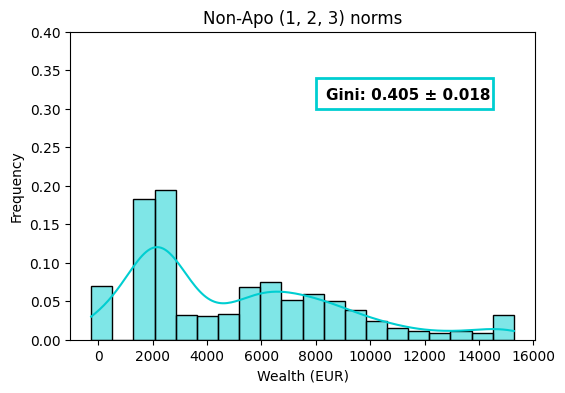

[0.43099897307076585, 0.40840718614729044, 0.38142921362843885, 0.4213395521271772, 0.4092835674698564, 0.4078434935901064, 0.426103150728777, 0.39097437272529323, 0.3740875451098927, 0.40357528277541355]


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

desired_order = ['(0, 1, 5)']
combination_labels = ['Non-Apo (1, 2, 3) norms']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
colors = ['darkturquoise'] #salmon

gini_coefficients = []

# Iterate over the desired combinations and plot the wealth distribution for each
for i, combination in enumerate(desired_order[:1]):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]

    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]

        # Calculate cumulative wealth distribution for the current sample
        wealth_values = np.sort(sample_data['wealth'])
        cumulative_wealth = np.cumsum(wealth_values)
        cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

        # Calculate Gini coefficient for the current sample
        n = len(cumulative_percentage)
        area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
        area_of_inequality = 0.5 - area_under_curve
        gini_coefficient = area_of_inequality / 0.5

        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficients.append((np.mean(sample_ginis), gini_std))
    
  # Plot the distribution of wealth for the current combination with a unique color
    sns.histplot(data=filtered_data, x='wealth', bins=20, color=colors[i], ax=axs, kde=True, stat='probability')
    homeless_wealth = filtered_data[filtered_data['status'] == 'homeless']['wealth']

    axs.text(0.55, 0.78, f'Gini: {np.mean(sample_ginis):.3f} \u00B1 {gini_std:.3f}', weight='bold', fontsize=11, transform=axs.transAxes)
    square_color = colors[i]
    frame = plt.Rectangle((0.53, 0.75), 0.38, 0.10, fill=False, edgecolor=square_color, linewidth=2, transform=axs.transAxes)
    axs.add_patch(frame)
    
    axs.set_xlabel('Wealth (EUR)')
    axs.set_ylabel('Frequency')
    axs.set_ylim(0, 0.4
                )
    axs.set_title(f'{combination_labels[i]}')

plt.show()
print(sample_ginis)

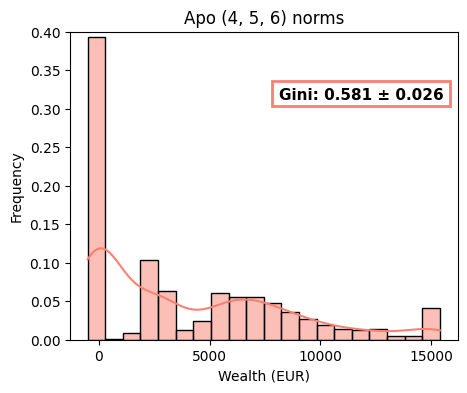

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

desired_order = ['(2, 3, 4)']
combination_labels = ['Apo (4, 5, 6) norms']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
colors = ['salmon'] #salmon

gini_coefficients = []

# Iterate over the desired combinations and plot the wealth distribution for each
for i, combination in enumerate(desired_order[:1]):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]

    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]

        # Calculate cumulative wealth distribution for the current sample
        wealth_values = np.sort(sample_data['wealth'])
        cumulative_wealth = np.cumsum(wealth_values)
        cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

        # Calculate Gini coefficient for the current sample
        n = len(cumulative_percentage)
        area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
        area_of_inequality = 0.5 - area_under_curve
        gini_coefficient = area_of_inequality / 0.5

        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficients.append((np.mean(sample_ginis), gini_std))
    
  # Plot the distribution of wealth for the current combination with a unique color
    sns.histplot(data=filtered_data, x='wealth', bins=20, color=colors[i], ax=axs, kde=True, stat='probability')
    homeless_wealth = filtered_data[filtered_data['status'] == 'homeless']['wealth']

    axs.text(0.54, 0.78, f'Gini: {np.mean(sample_ginis):.3f} \u00B1 {gini_std:.3f}', weight='bold', fontsize=11, transform=axs.transAxes)
    square_color = colors[i]
    frame = plt.Rectangle((0.52, 0.76), 0.46, 0.08, fill=False, edgecolor=square_color, linewidth=2, transform=axs.transAxes)
    axs.add_patch(frame)
    axs.set_xlabel('Wealth (EUR)')
    axs.set_xticks(range(0, 16000, 5000))
    axs.set_ylabel('Frequency')
    axs.set_ylim(0, 0.4)
    axs.set_title(f'{combination_labels[i]}')

plt.show()
bars = axs.patches
left_bar_height = bars[0].get_height()

## Individual effect of the norms on the simulation

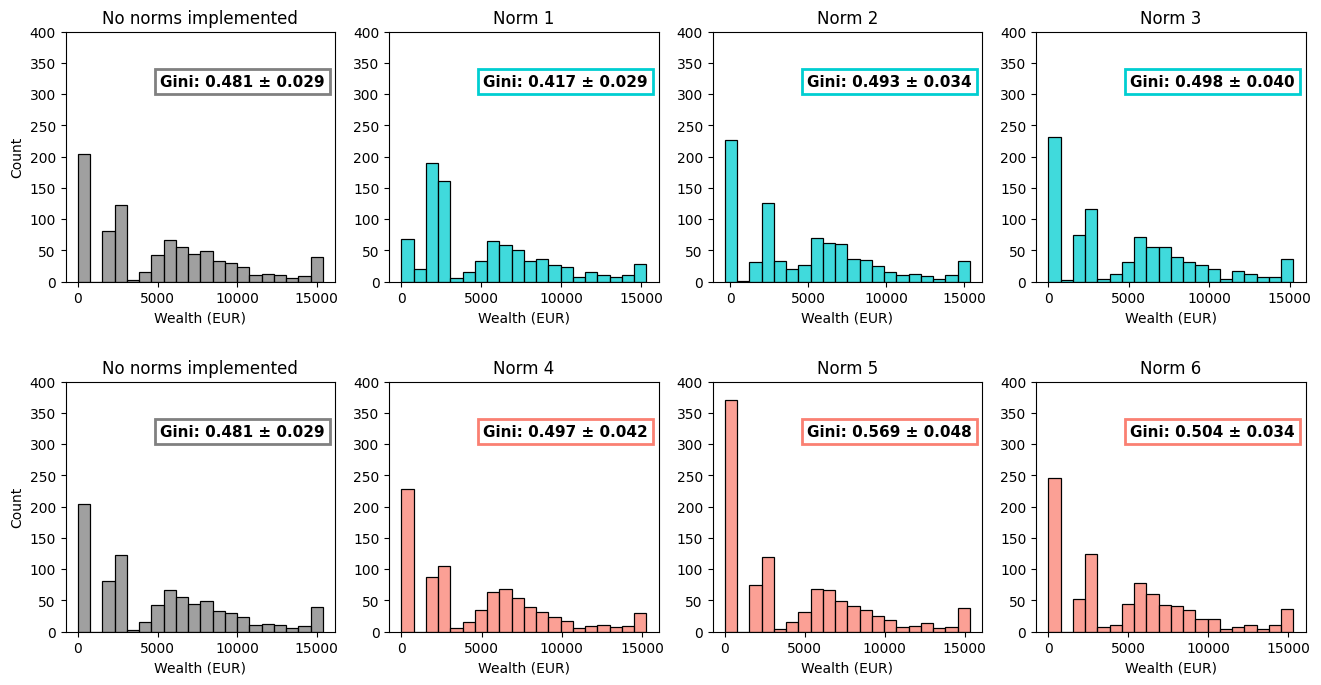

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

desired_order = ['()', '(0,)', '(1,)', '(5,)', '()', '(2,)', '(3,)', '(4,)']
combination_labels = ['0', '1', '2', '3', '0', '4', '5', '6']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
colors = ['grey', 'darkturquoise', 'darkturquoise', 'darkturquoise', 'grey', 'salmon', 'salmon', 'salmon']

gini_coefficients = []

# Iterate over the desired combinations and plot the wealth distribution for each
for i, combination in enumerate(desired_order[:8]):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]
    row = i // 4
    col = i % 4
    
    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]

        # Calculate cumulative wealth distribution for the current sample
        wealth_values = np.sort(sample_data['wealth'])
        cumulative_wealth = np.cumsum(wealth_values)
        cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

        # Calculate Gini coefficient for the current sample
        n = len(cumulative_percentage)
        area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
        area_of_inequality = 0.5 - area_under_curve
        gini_coefficient = area_of_inequality / 0.5

        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficients.append((np.mean(sample_ginis), gini_std))
    
  # Plot the distribution of wealth for the current combination with a unique color
    sns.histplot(data=filtered_data, x='wealth', bins=20, color=colors[i], ax=axs[row,col])
    homeless_wealth = filtered_data[filtered_data['status'] == 'homeless']['wealth']

    axs[row,col].text(0.35, 0.78, f'Gini: {np.mean(sample_ginis):.3f} \u00B1 {gini_std:.3f}', weight='bold', fontsize=11, transform=axs[row,col].transAxes)
    square_color = colors[i]
    frame = plt.Rectangle((0.33, 0.75), 0.65, 0.10, fill=False, edgecolor=square_color, linewidth=2, transform=axs[row,col].transAxes)
    axs[row,col].add_patch(frame)
    
    axs[row, col].set_xlabel('Wealth (EUR)')
    
    if col == 0:
        axs[row, col].set_ylabel('Count')
        axs[row, col].set_title(f'No norms implemented')
    else:
        axs[row, col].set_ylabel('')
        axs[row, col].set_title(f'Norm {combination_labels[i]}')
    axs[row, col].set_ylim(0, 400)
        
# Adjust the spacing between subplots and add extra spacing
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4)
plt.show()


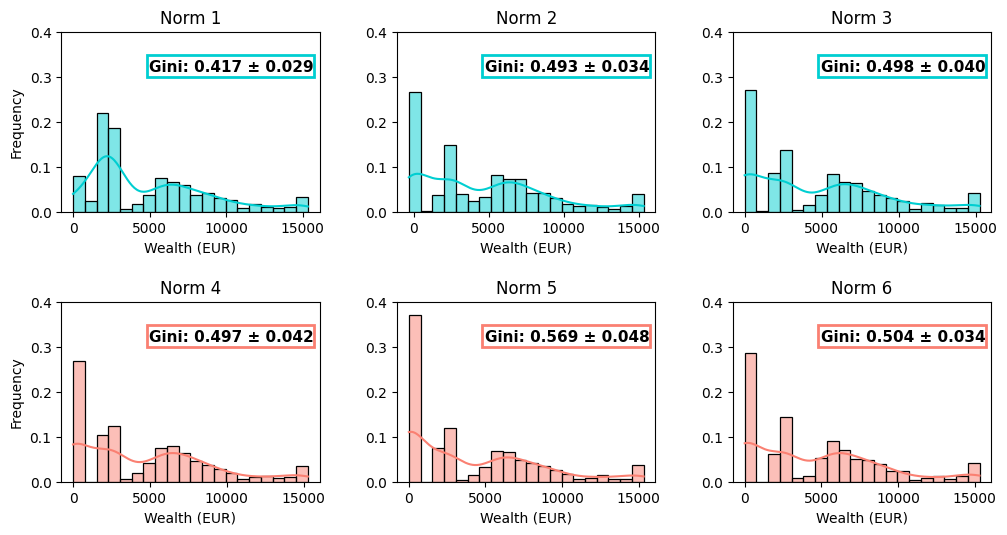

In [40]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

desired_order = [ '(0,)', '(1,)', '(5,)', '(2,)', '(3,)', '(4,)']
combination_labels = [ '1', '2', '3', '4', '5', '6']

filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

# Create a grid of subplots to display the wealth distributions
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
colors = ['darkturquoise', 'darkturquoise', 'darkturquoise', 'salmon', 'salmon', 'salmon']

gini_coefficients = []

# Iterate over the desired combinations and plot the wealth distribution for each
for i, combination in enumerate(desired_order[:6]):
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]
    row = i // 3
    col = i % 3
    
    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]

        # Calculate cumulative wealth distribution for the current sample
        wealth_values = np.sort(sample_data['wealth'])
        cumulative_wealth = np.cumsum(wealth_values)
        cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

        # Calculate Gini coefficient for the current sample
        n = len(cumulative_percentage)
        area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
        area_of_inequality = 0.5 - area_under_curve
        gini_coefficient = area_of_inequality / 0.5

        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficients.append((np.mean(sample_ginis), gini_std))
    
  # Plot the distribution of wealth for the current combination with a unique color
    sns.histplot(data=filtered_data, x='wealth', bins=20, color=colors[i], ax=axs[row,col], kde=True, stat='probability')
    homeless_wealth = filtered_data[filtered_data['status'] == 'homeless']['wealth']

    axs[row,col].text(0.34, 0.78, f'Gini: {np.mean(sample_ginis):.3f} \u00B1 {gini_std:.3f}', weight='bold', fontsize=11, transform=axs[row,col].transAxes)
    square_color = colors[i]
    frame = plt.Rectangle((0.33, 0.75), 0.65, 0.12, fill=False, edgecolor=square_color, linewidth=2, transform=axs[row,col].transAxes)
    axs[row,col].add_patch(frame)
    
    axs[row, col].set_xlabel('Wealth (EUR)')
    
    if col == 0:
        axs[row, col].set_ylabel('Frequency')
    else:
        axs[row, col].set_ylabel('')
    axs[row, col].set_title(f'Norm {combination_labels[i]}')
    axs[row, col].set_ylim(0, 0.4)
        
# Adjust the spacing between subplots and add extra spacing
plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.5, wspace= 0.3)
plt.show()


### Detection of the agents in the left lowest wealth bar 

INDIVIDUAL EFFECT

In [41]:
# Assuming norm_code is the code for the norm you're interested in, e.g., 
norm_code = '(0,)'
total_agents = len(cluster[cluster['norms_ind'] == norm_code])

# Calculate the total number of agents in the specified norm
total_agents_norm = len(cluster[cluster['norms_ind'] == norm_code])

# Calculate the proportion of agents with wealth < 600 in each status category
status_proportions = (cluster[(cluster['norms_ind'] == norm_code) & (cluster['wealth'] < 600)]
                      ['status'].value_counts(normalize=True))

# Now you can access the proportions for each status category
print(f"Proportion of homeless agents with wealth < 600: {status_proportions.get('homeless', 0) * total_agents_norm / total_agents * 100:.2f}%")
print(f"Proportion of unemployed agents with wealth < 600: {status_proportions.get('unemployed', 0) * total_agents_norm / total_agents * 100:.2f}%")
print(f"Proportion of employed agents with wealth < 600: {status_proportions.get('employed', 0) * total_agents_norm / total_agents * 100:.2f}%")
print(f"Proportion of financially broke agents with wealth < 600: {status_proportions.get('financially_broke', 0) * total_agents_norm / total_agents * 100:.2f}%")


Proportion of homeless agents with wealth < 600: 100.00%
Proportion of unemployed agents with wealth < 600: 0.00%
Proportion of employed agents with wealth < 600: 0.00%
Proportion of financially broke agents with wealth < 600: 0.00%


In [42]:
cluster.loc[(cluster['norms_ind'] == '()') & (cluster['wealth'] < 600)]['status'].value_counts()

status
unemployed    147
homeless       58
Name: count, dtype: int64

In [43]:
cluster.loc[(cluster['norms_ind'] == '(1,)')]['status'].value_counts() #veig que aqui directament no hi ha homeless, ja son unemployed

status
employed      435
unemployed    227
retired       188
Name: count, dtype: int64

COLLECTIVE EFFECT

In [44]:
#cluster.loc[(cluster['norms_ind'] == '(2, 3, 4)') & (cluster['wealth'] < 2000)]
cluster.loc[(cluster['norms_ind'] == '(0, 1, 5)') & (cluster['wealth'] < 500)]['status'].value_counts() #veig que aqui directament no hi ha homeless, ja son unemployed

status
unemployed    56
employed       4
Name: count, dtype: int64

In [45]:
#cluster.loc[(cluster['norms_ind'] == '(2, 3, 4)') & (cluster['wealth'] < 2000)]
cluster.loc[(cluster['norms_ind'] == '(2, 3, 4)') & (cluster['wealth'] < 1000)]['status'].value_counts() #veig que aqui directament no hi ha homeless, ja son unemployed

status
homeless    393
Name: count, dtype: int64

## Computation of the Gini Coefficient for all the Norm Combinations

Also, we can obtain the list of norms that maximally optimize and minimum optimize gini coefficient. We can compute uncertainties for each of the combination of norms. We must compute the cumm distributions for each of the 10 samples and then with this 10 ginis, do the mean and the low and high error. And show these errors in the general plot, as error bars. 

In [46]:
def compute_gini_coefficient(data):
    wealth_values = np.sort(data)
    cumulative_wealth = np.cumsum(wealth_values)
    cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

    n = len(cumulative_percentage)
    area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
    area_of_inequality = 0.5 - area_under_curve
    gini_coefficient = area_of_inequality / 0.5
    
    return gini_coefficient

combinations = cluster['norms_ind'].unique()
gini_coefficients = []

for combination in combinations:
    filtered_data = cluster[cluster['norms_ind'] == combination] #['wealth']
    sample_ginis = []

    for sample in range(10):  # Assuming you have 10 samples for each combination
        sample_data = filtered_data[filtered_data['AgentID'] % 10 == sample]['wealth']

        gini_coefficient = compute_gini_coefficient(sample_data)
        sample_ginis.append(gini_coefficient)

    gini_std = np.std(sample_ginis)
    gini_coefficient = np.mean(sample_ginis)
    
    gini_coefficients.append((combination, gini_coefficient, gini_std))

sorted_combinations = sorted(gini_coefficients, key=lambda x: x[1])

for combination, gini_coefficient, gini_std in sorted_combinations:
    print(f'Combination: {combination}   Gini Coefficient: {gini_coefficient:.6f} \u00B1 {gini_std:.6f}')

Combination: (0, 1, 5)   Gini Coefficient: 0.405404 ± 0.017705
Combination: (0, 1)   Gini Coefficient: 0.406938 ± 0.028592
Combination: (0, 1, 4, 5)   Gini Coefficient: 0.407577 ± 0.015334
Combination: (0, 4)   Gini Coefficient: 0.412118 ± 0.011537
Combination: (0, 4, 5)   Gini Coefficient: 0.414709 ± 0.026047
Combination: (0, 2)   Gini Coefficient: 0.416336 ± 0.025530
Combination: (0,)   Gini Coefficient: 0.416911 ± 0.028839
Combination: (0, 5)   Gini Coefficient: 0.418949 ± 0.016226
Combination: (0, 1, 4)   Gini Coefficient: 0.418979 ± 0.021756
Combination: (0, 1, 2, 5)   Gini Coefficient: 0.421730 ± 0.022576
Combination: (0, 1, 2)   Gini Coefficient: 0.422363 ± 0.027628
Combination: (0, 2, 5)   Gini Coefficient: 0.429331 ± 0.023823
Combination: (0, 3, 4, 5)   Gini Coefficient: 0.474729 ± 0.029071
Combination: (0, 1, 2, 4, 5)   Gini Coefficient: 0.477271 ± 0.036440
Combination: ()   Gini Coefficient: 0.480862 ± 0.028922
Combination: (1, 4, 5)   Gini Coefficient: 0.484851 ± 0.045035
C

        combination      gini     error  proportion_APO
0         (0, 1, 5)  0.405404  0.017705        0.000000
1            (0, 1)  0.406938  0.028592        0.000000
2      (0, 1, 4, 5)  0.407577  0.015334        0.250000
3            (0, 4)  0.412118  0.011537        0.500000
4         (0, 4, 5)  0.414709  0.026047        0.333333
..              ...       ...       ...             ...
59           (3, 5)  0.581026  0.039848        0.500000
60     (1, 2, 3, 5)  0.585211  0.029203        0.500000
61        (2, 3, 5)  0.586993  0.018401        0.666667
62        (3, 4, 5)  0.590080  0.035971        0.666667
63  (1, 2, 3, 4, 5)  0.600128  0.019525        0.600000

[63 rows x 4 columns]


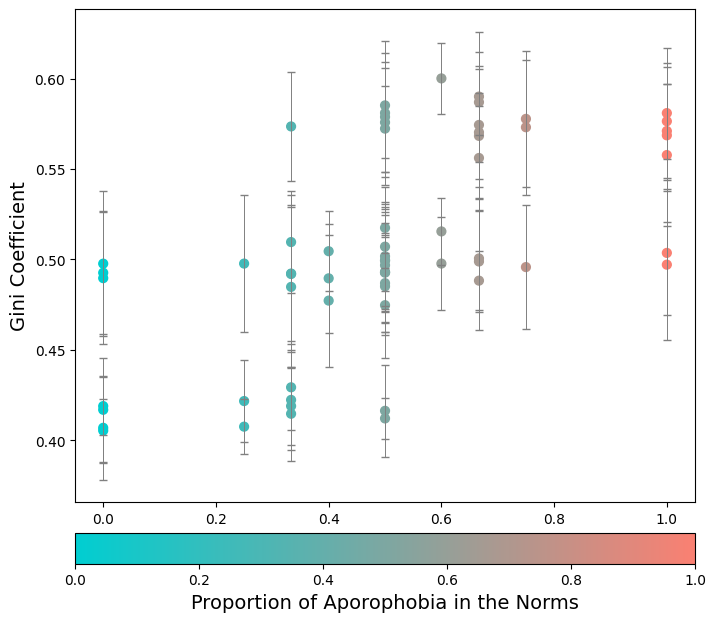

In [47]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.DataFrame(sorted_combinations, columns=['combination', 'gini', 'error'])
df = df.loc[df['combination'] != '()']

aporophobic_norms = (2, 3, 4)
df['combination'] = df['combination'].apply(ast.literal_eval)  # Convert string to tuple

def calculate_proportion_APO(combination):
    return len(set(combination) & set(aporophobic_norms)) / len(combination)

df['proportion_APO'] = df['combination'].apply(calculate_proportion_APO)

plt.figure(figsize=(8, 8))

# Define custom colormap between 'darkturquoise' and 'salmon'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_colormap', ['darkturquoise', 'salmon'], N=256)

# Scatter plot with colored points using the custom colormap
plt.scatter(df['proportion_APO'], df['gini'], c=df['proportion_APO'],
            cmap=custom_cmap, marker='o', linestyle='-', s=40)
print(df)
# Add error bars
plt.errorbar(df['proportion_APO'], df['gini'], yerr=df['error'], fmt='none', ecolor='gray', elinewidth=0.7, capsize=3, label='Error Bars')

plt.ylabel('Gini Coefficient', fontsize=14)
#plt.grid(True)  # Enable the grid

cbar = plt.colorbar(orientation='horizontal', pad=0.05)  # Add colorbar
cbar.set_label('Proportion of Aporophobia in the Norms', fontsize=14)  # Adjust the label size here
plt.show()



Now, let's mark the highest and lowest Gini obtained with the corresponding combination of norms, and highlight those combinations that contain Norm1, which seems to be the norm contributing the most to an egalitarian distribution. 

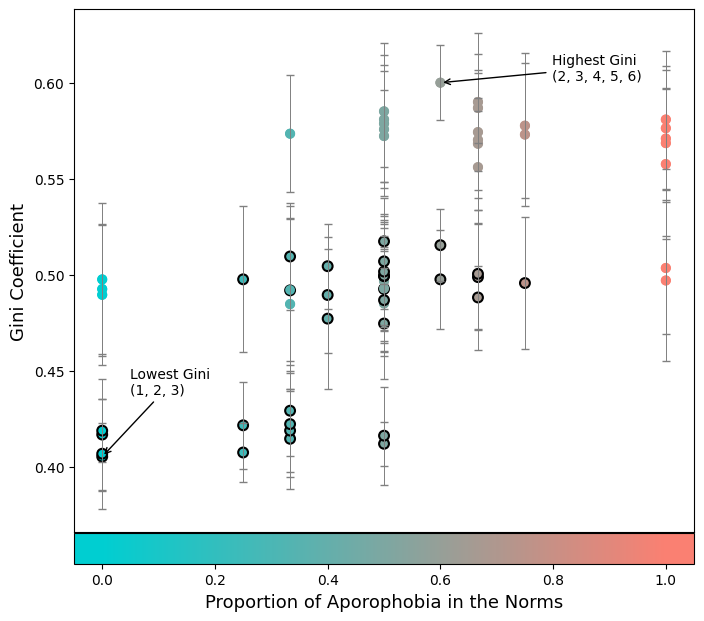

In [48]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.DataFrame(sorted_combinations, columns=['combination', 'gini', 'error'])
df = df.loc[df['combination'] != '()']

aporophobic_norms = (2, 3, 4)
df['combination'] = df['combination'].apply(ast.literal_eval)  # Convert string to tuple

def calculate_proportion_APO(combination):
    return len(set(combination) & set(aporophobic_norms)) / len(combination)

df['proportion_APO'] = df['combination'].apply(calculate_proportion_APO)

plt.figure(figsize=(8, 8))

# Define custom colormap between 'darkturquoise' and 'salmon'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_colormap', ['darkturquoise', 'salmon'], N=256)

# Scatter plot with colored points using the custom colormap
plt.scatter(df['proportion_APO'], df['gini'], c=df['proportion_APO'],
            cmap=custom_cmap, marker='o', linestyle='-', s=40)
# Add error bars
plt.errorbar(df['proportion_APO'], df['gini'], yerr=df['error'], fmt='none', ecolor='gray', elinewidth=0.7, capsize=3, label='Error Bars')
# Get the combination with the lowest and highest Gini coefficients
lowest_combination, lowest_gini, uncertlow = sorted_combinations[0]
highest_combination, highest_gini, uncerthigh = sorted_combinations[-1]
lowest_combination = '(1, 2, 3)'
highest_combination = '(2, 3, 4, 5, 6)'

# Annotate the plot with the combinations
plt.annotate(f'Lowest Gini \n{lowest_combination}', 
             xy=(df.loc[df['gini'] == lowest_gini, 'proportion_APO'].values[0], lowest_gini),
             xytext=(20, 45), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

plt.annotate(f'Highest Gini \n{highest_combination}', 
             xy=(df.loc[df['gini'] == highest_gini, 'proportion_APO'].values[0], highest_gini),
             xytext=(80, 2), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

plt.ylabel('Gini Coefficient', fontsize=13)
plt.scatter(df['proportion_APO'], df['gini'], c=df['proportion_APO'],
            cmap=custom_cmap, marker='o', s=50, edgecolors=['black' if 0 in combination else 'none' for combination in df['combination']], linewidth=1.5)
    
#plt.grid(True)  # Enable the grid

cbar = plt.colorbar(orientation='horizontal',  pad= 0.0005, extend= 'both', extendrect= True)  # Add colorbar
cbar.set_label('Proportion of Aporophobia in the Norms', fontsize=13)  # Adjust the label size here
#cbar = plt.colorbar(sm, ticks=[0, 0.25, 0.5, 0.75, 1], orientation = 'horizontal', pad= 0.0005, extend= 'both', extendrect= True)
plt.xticks([])
plt.show()

In [49]:
#cluster = cluster.loc[cluster['status'] != 'student']
combinations = cluster['norms_ind'].unique()
gini_coefficients = []

for combination in combinations:
    filtered_data = cluster[cluster['norms_ind'] == combination]['wealth']
    num_samples = len(filtered_data) // 100  # Calculate the number of 100-line batches

    for i in range(num_samples):
        start_idx = i * 100
        end_idx = (i + 1) * 100
        batch_data = filtered_data.iloc[start_idx:end_idx]
        
        if i == num_samples - 1:  # Last batch, calculate Gini coefficient
            gini_coefficient = compute_gini_coefficient(batch_data)
            gini_coefficients.append((combination, gini_coefficient))

sorted_combinations = sorted(gini_coefficients, key=lambda x: x[1])

for combination, gini_coefficient in sorted_combinations:
    print(f'Combination: {combination}   Gini Coefficient: {gini_coefficient:.6f}')


Combination: (0, 1)   Gini Coefficient: 0.384578
Combination: (0, 1, 5)   Gini Coefficient: 0.388704
Combination: (0, 1, 2)   Gini Coefficient: 0.397730
Combination: (0, 1, 4)   Gini Coefficient: 0.398553
Combination: (0, 4, 5)   Gini Coefficient: 0.404567
Combination: (0, 1, 4, 5)   Gini Coefficient: 0.404569
Combination: (0, 4)   Gini Coefficient: 0.409559
Combination: (0, 5)   Gini Coefficient: 0.431030
Combination: (0, 2, 5)   Gini Coefficient: 0.432744
Combination: (4, 5)   Gini Coefficient: 0.434646
Combination: (0,)   Gini Coefficient: 0.442495
Combination: (0, 3, 5)   Gini Coefficient: 0.447599
Combination: (0, 2)   Gini Coefficient: 0.453201
Combination: (1, 4)   Gini Coefficient: 0.453280
Combination: (0, 2, 3)   Gini Coefficient: 0.457325
Combination: (1,)   Gini Coefficient: 0.463123
Combination: (5,)   Gini Coefficient: 0.463434
Combination: (0, 1, 3, 4)   Gini Coefficient: 0.465161
Combination: (0, 3, 4, 5)   Gini Coefficient: 0.465726
Combination: (2,)   Gini Coefficient

In [50]:
def compute_gini_uncertainty(data):
    num_samples = len(data)
    mean_gini = np.mean(data)
    uncertainty = np.sum((data - mean_gini) ** 2) / num_samples
    return uncertainty

def compute_gini_coefficient(data):
    wealth_values = np.sort(data)
    cumulative_wealth = np.cumsum(wealth_values)
    cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

    n = len(cumulative_percentage)
    area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
    area_of_inequality = 0.5 - area_under_curve
    gini_coefficient = area_of_inequality / 0.5
    
    return gini_coefficient

#cluster = cluster.loc[cluster['status'] != 'student']
combinations = cluster['norms_ind'].unique()
gini_coefficients = []

for combination in combinations:
    filtered_data = cluster[cluster['norms_ind'] == combination]['wealth']
    gini_values = []

    for i in range(10):
        sample_data = filtered_data[cluster['AgentID'] % 100 == i]
        gini_coefficient = compute_gini_coefficient(sample_data)
        gini_values.append(gini_coefficient)

    uncertainty = compute_gini_uncertainty(gini_values)
    gini_coefficients.append((combination, np.mean(gini_values), uncertainty))

sorted_combinations = sorted(gini_coefficients, key=lambda x: x[1])

for combination, mean_gini, gini_uncertainty in sorted_combinations:
    print(f'Combination: {combination}   Mean Gini Coefficient: {mean_gini:.6f}   Gini Uncertainty: {gini_uncertainty:.6f}')


Combination: (0, 1, 2, 5)   Mean Gini Coefficient: 0.339259   Gini Uncertainty: 0.006630
Combination: (0, 4, 5)   Mean Gini Coefficient: 0.349154   Gini Uncertainty: 0.004280
Combination: (0, 4)   Mean Gini Coefficient: 0.365879   Gini Uncertainty: 0.002626
Combination: (0,)   Mean Gini Coefficient: 0.367837   Gini Uncertainty: 0.004395
Combination: (0, 1, 4)   Mean Gini Coefficient: 0.370782   Gini Uncertainty: 0.015102
Combination: (0, 1, 4, 5)   Mean Gini Coefficient: 0.371042   Gini Uncertainty: 0.005752
Combination: (0, 5)   Mean Gini Coefficient: 0.387426   Gini Uncertainty: 0.004998
Combination: (0, 1)   Mean Gini Coefficient: 0.391137   Gini Uncertainty: 0.006024
Combination: (0, 1, 5)   Mean Gini Coefficient: 0.391967   Gini Uncertainty: 0.005155
Combination: (0, 2, 5)   Mean Gini Coefficient: 0.394952   Gini Uncertainty: 0.011121
Combination: (4,)   Mean Gini Coefficient: 0.396106   Gini Uncertainty: 0.005258
Combination: (0, 2)   Mean Gini Coefficient: 0.402938   Gini Uncert

## Wealth distributions variation, 2024

In [51]:
# Reescric les dades per a que 0,1,5 non-apo siguin 1,2,3 i 2,3,4 apo siguin 4,5,6
cluster1 = cluster[['norms_ind','wealth']]
cluster1['norms_ind'].unique()
#cluster1['norms_ind'] = cluster1['norms_ind'].apply(lambda x: tuple(int(digit) + 1 if int(digit) == 3 else int(digit) for digit in x.strip('()').split(',')) if x.strip('()') else (0,))
cluster1

,norms_ind,wealth
0,(),12846.783333
1,(),9050.033333
2,(),5735.325000
3,(),2637.675000
4,(),2024.450000
...,...,...
63995,"(0, 1, 2, 3, 4, 5)",1911.025000
63996,"(0, 1, 2, 3, 4, 5)",0.000000
63997,"(0, 1, 2, 3, 4, 5)",2871.575000
63998,"(0, 1, 2, 3, 4, 5)",0.000000


In [52]:
import numpy as np

def compute_gini_uncertainty(data):
    num_samples = len(data)
    mean_gini = np.mean(data)
    uncertainty = np.sum((data - mean_gini) ** 2) / num_samples
    return uncertainty

def compute_gini_coefficient(data):
    wealth_values = np.sort(data)
    cumulative_wealth = np.cumsum(wealth_values)
    cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

    n = len(cumulative_percentage)
    area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
    area_of_inequality = 0.5 - area_under_curve
    gini_coefficient = area_of_inequality / 0.5
    
    return gini_coefficient

combinations = cluster['norms_ind'].unique()
gini_values_dict = {}

for combination in combinations:
    filtered_data = cluster[cluster['norms_ind'] == combination]['wealth']
    gini_values = []

    for i in range(10):
        sample_data = filtered_data[cluster['AgentID'] % 100 == i]
        gini_coefficient = compute_gini_coefficient(sample_data)
        gini_values.append(gini_coefficient)

    uncertainty = compute_gini_uncertainty(gini_values)
    gini_values_dict[combination] = {'mean': np.mean(gini_values), 'uncertainty': uncertainty, 'values': gini_values}

sorted_combinations = sorted(gini_values_dict.items(), key=lambda x: x[1]['mean'])

for combination, values in sorted_combinations:
    mean_gini = values['mean']
    gini_uncertainty = values['uncertainty']
    all_gini_values = values['values']
    
    #print(f'Combination: {combination}   Mean Gini Coefficient: {mean_gini:.6f}   Gini Uncertainty: {gini_uncertainty:.6f}')
    #print(f'All Gini Values: {all_gini_values}')
all_gini_values_for_plotting = []

# Iterate through combinations and extract Gini values
for combination, values in sorted_combinations:
    all_gini_values_for_plotting.append(values['values'])

# # Create a boxplot
# plt.figure(figsize=(10, 6))
# plt.boxplot(all_gini_values_for_plotting, labels=combinations, vert=True, patch_artist=True)
# plt.xlabel('Combinations of Norms')
# plt.ylabel('Gini')
# plt.xticks(rotation=90)
# #plt.title('Variation of Gini Coefficients for Different Combinations of Norms')
# plt.show()


C:\Users\albaa\AppData\Local\Temp\ipykernel_10444\3477393141.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation = 'horizontal', pad= 0.0005, extend= 'both', extendrect= True)


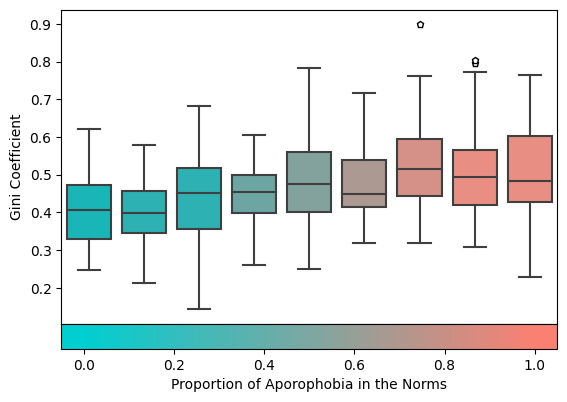

In [65]:
# THE GOOD ONE
import seaborn as sns
import matplotlib.pyplot as plt
# with customized colors
df = pd.DataFrame([(combination, values['mean'], values['uncertainty'], values['values']) for combination, values in gini_values_dict.items()],
                  columns=['combination', 'mean', 'uncertainty', 'values'])
df = df.loc[df['combination'] != '()']

aporophobic_norms = (2, 3, 4)
df['combination'] = df['combination'].apply(ast.literal_eval)  # Convert string to tuple

def calculate_proportion_APO(combination):
    return len(set(combination) & set(aporophobic_norms)) / len(combination)

df['proportion_APO'] = df['combination'].apply(calculate_proportion_APO)
df_exploded = df.explode('values')
# Define a custom colormap
custom_cmap = sns.blend_palette(['darkturquoise', 'salmon'], as_cmap=True)
colors = [custom_cmap(i / (custom_cmap.N - 1)) for i in range(custom_cmap.N)]

# Create the boxplot with gradient colors
boxplot = sns.boxplot(x='proportion_APO', y='values', data=df_exploded, palette = [custom_cmap(-0.5), custom_cmap(0.1), custom_cmap(0.1), custom_cmap(0.4), custom_cmap(0.5), custom_cmap(0.7), custom_cmap(0.9), custom_cmap(1.1), custom_cmap(1.2)], flierprops=dict(markeredgecolor='black', markerfacecolor='white', marker='p', markersize=5))

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # dummy empty array for the data range
cbar = plt.colorbar(sm, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation = 'horizontal', pad= 0.0005, extend= 'both', extendrect= True)
cbar.set_label('Proportion of Aporophobia in the Norms', fontsize=10)
plt.xticks([])
plt.ylabel('Gini Coefficient', fontsize= 10)
plt.show()


C:\Users\albaa\AppData\Local\Temp\ipykernel_10444\4104559390.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation='horizontal', pad=0.0005, extend='both', extendrect=True)


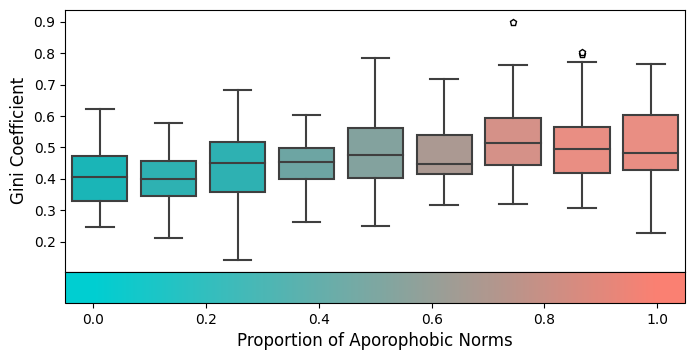

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a figure with the desired size (replace width and height with your values)
fig = plt.figure(figsize=(8, 4))

# Create the boxplot with gradient colors
boxplot = sns.boxplot(x='proportion_APO', y='values', data=df_exploded, palette=[custom_cmap(-0.5), custom_cmap(0.1), custom_cmap(0.1), custom_cmap(0.4), custom_cmap(0.5), custom_cmap(0.7), custom_cmap(0.9), custom_cmap(1.1), custom_cmap(1.2)], flierprops=dict(markeredgecolor='black', markerfacecolor='white', marker='p', markersize=5))

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # dummy empty array for the data range
cbar = plt.colorbar(sm, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation='horizontal', pad=0.0005, extend='both', extendrect=True)
cbar.set_label('Proportion of Aporophobic Norms', fontsize=12)
plt.xticks([])
plt.ylabel('Gini Coefficient', fontsize=12)
# Display the plot
plt.show()


C:\Users\albaa\AppData\Local\Temp\ipykernel_10444\4101286459.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), label='Proportion of Aporophobia in the Norms')


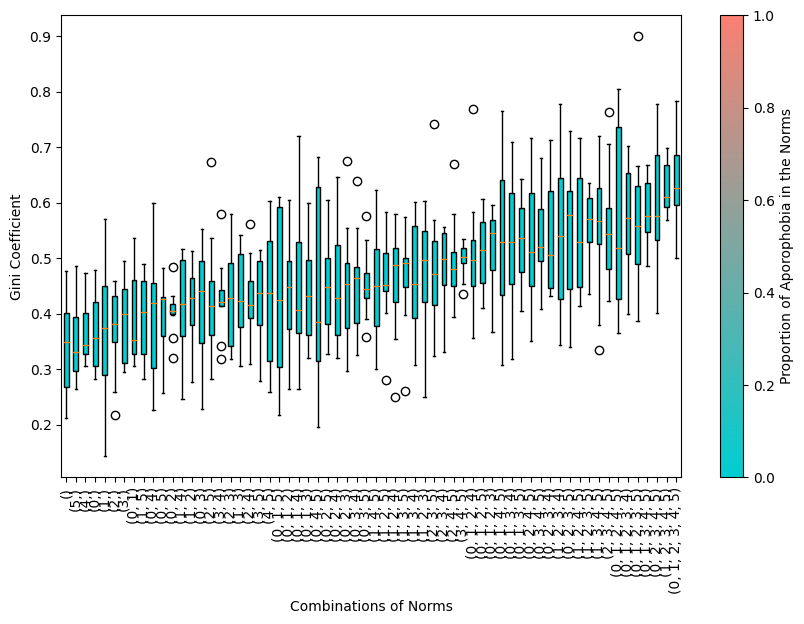

In [66]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Assuming cluster and other required functions are defined previously

def compute_gini_uncertainty(data):
    num_samples = len(data)
    mean_gini = np.mean(data)
    uncertainty = np.sum((data - mean_gini) ** 2) / num_samples
    return uncertainty

def compute_gini_coefficient(data):
    wealth_values = np.sort(data)
    cumulative_wealth = np.cumsum(wealth_values)
    cumulative_percentage = cumulative_wealth / np.sum(wealth_values)

    n = len(cumulative_percentage)
    area_under_curve = np.trapz(cumulative_percentage, dx=1/n)
    area_of_inequality = 0.5 - area_under_curve
    gini_coefficient = area_of_inequality / 0.5
    
    return gini_coefficient

combinations = cluster['norms_ind'].unique()
gini_values_dict = {}

for combination in combinations:
    filtered_data = cluster[cluster['norms_ind'] == combination]['wealth']
    gini_values = []

    for i in range(10):
        sample_data = filtered_data[cluster['AgentID'] % 100 == i]
        gini_coefficient = compute_gini_coefficient(sample_data)
        gini_values.append(gini_coefficient)

    uncertainty = compute_gini_uncertainty(gini_values)
    proportion_APO = len(set(combination) & set(aporophobic_norms)) / len(combination)
    gini_values_dict[combination] = {'mean': np.mean(gini_values), 'uncertainty': uncertainty, 'values': gini_values, 'proportion_APO': proportion_APO}

# Sort by mean Gini coefficient
sorted_combinations = sorted(gini_values_dict.items(), key=lambda x: x[1]['mean'])

# Extract data for boxplot
boxplot_data = [values['values'] for combination, values in sorted_combinations]

# Create a boxplot
plt.figure(figsize=(10, 6))
box = plt.boxplot(boxplot_data, labels=combinations, vert=True, patch_artist=True)

# Set box colors based on the custom colormap
proportions = [values['proportion_APO'] for combination, values in sorted_combinations]
for patch, color in zip(box['boxes'], custom_cmap(proportions)):
    patch.set_facecolor(color)

plt.xlabel('Combinations of Norms')
plt.ylabel('Gini Coefficient')
plt.xticks(rotation=90)
plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), label='Proportion of Aporophobia in the Norms')
plt.show()

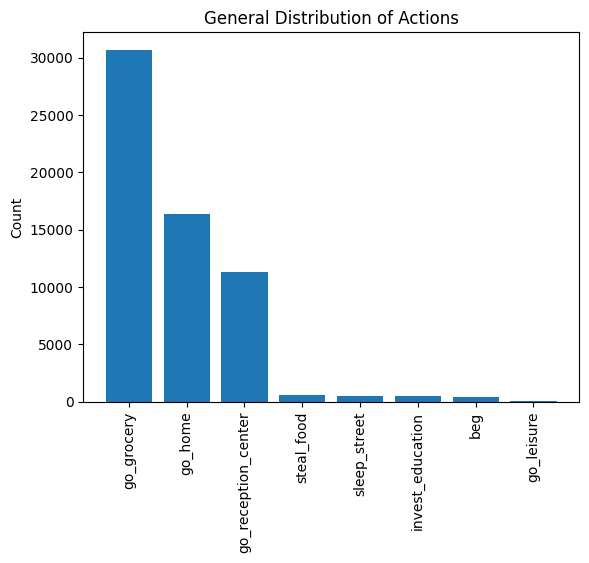

In [60]:

import matplotlib.pyplot as plt
import pandas as pd
import ast
#DISTRIBUTION OF ACTIONS
cluster = cluster.dropna(subset=["actions"])
# Calculate value counts
action_counts = cluster["actions"].value_counts()
plt.bar(action_counts.index, action_counts.values)
plt.ylabel("Count")
plt.title("General Distribution of Actions")
plt.xticks(rotation=90)
plt.show()

C:\Users\albaa\AppData\Local\Temp\ipykernel_10444\31245276.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
C:\Users\albaa\AppData\Local\Temp\ipykernel_10444\31245276.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)


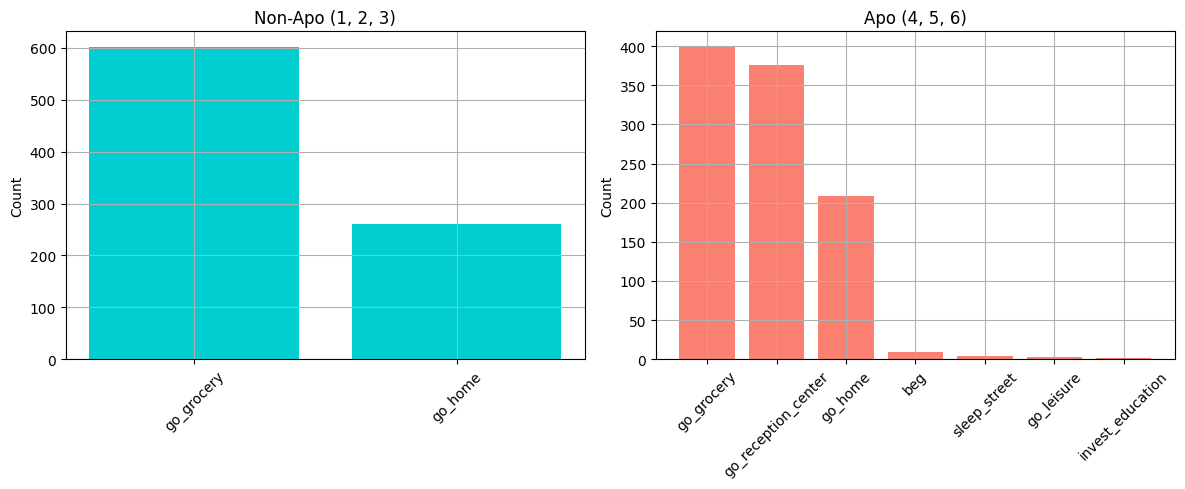

actions
go_grocery             399
go_reception_center    376
go_home                208
beg                      9
sleep_street             4
go_leisure               3
invest_education         1
Name: count, dtype: int64

In [61]:
import matplotlib.pyplot as plt
import numpy as np

desired_order = ['(0, 1, 5)', '(2, 3, 4)']
combination_labels = ['Non-Apo (1, 2, 3)', 'Apo (4, 5, 6)']
filtered_cluster = cluster[cluster['norms_ind'].isin(desired_order)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ['darkturquoise', 'salmon']

# Iterate over the desired combinations and plot the histogram for each one
for i, combination in enumerate(desired_order):
    # Filter the DataFrame for the current combination
    filtered_data = filtered_cluster[filtered_cluster['norms_ind'] == combination]
    
    # Compute the value counts of actions
    action_values = filtered_data['actions'].value_counts()
    
    # Plot the histogram of actions for the current combination
    axs[i].bar(action_values.index, action_values.values, color=colors[i])
    axs[i].grid()
    #axs[i].set_xlabel('Actions')
    axs[i].set_ylabel('Count')
    axs[i].set_title(combination_labels[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()
# Display the plot
plt.show()
cluster[cluster['norms_ind'] =='(0, 1, 5)']['actions'].value_counts()
cluster[cluster['norms_ind'] =='(2, 3, 4)']['actions'].value_counts()

The actions variability is really poor for the Non-Apo norm combination. 